# Exploration of the King County Housing Dataset

My goal in this notebook is to provide plauseable insight into ways a homeowner can make renovations to their current home in order to make it more attactive to buyers and/or sell for a high price.

Let's first import some tools and take our first look at the dataset

In [43]:
#All the imports that we may or may not need
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
#The data
df = pd.read_csv("data/kc_house_data.csv")
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [44]:
df.corr().price.sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.395734
bedrooms         0.308787
lat              0.306692
waterfront       0.276295
floors           0.256804
yr_renovated     0.129599
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
condition        0.036056
long             0.022036
id              -0.016772
zipcode         -0.053402
Name: price, dtype: float64

# Model 1

## 1.a Cleaning and Prepping the data 

Sweet. Now that we can get a good look at what we're working with we will start to clean the data a bit to get it ready for modeling. First, we can already start to eliminate some columns that are irrelevant.
Here's what we can get rid of:

- **id** - the specific id of the house doesn't matter, we just need the data from it to make a model
- **date** - like id, date sold doesn't matter, we just need the data about the house to make a model
- **view** - this is not about the view from the house but how many times it had been view. Not particularly useful
- **zipcode** - this is only helpful if we have information about how safe the neighborhood is. We do not so we will ignore this one
- **lat** - latitude of the house isn't quite as usful as an address
- **long** - like with lat, longitude of a house isn't quite as usful as an address
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors. Not usful
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors. Not usful

In [45]:
# Remove the above mentioned columns
df.drop(['id', 'date', 'view', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
# Sanity Check
dfListDrop = list(df.columns)
dfListDrop

Awesome! Now, let's take a look at our data and see if any columns have NaN (missing) values that might get in the way.

In [47]:
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
dtype: int64

Okay, it looks like we have a couple. Let's take a closer look...

In [48]:
print(df['waterfront'].value_counts())
print('column "waterfront" has', df['waterfront'].isna().sum(), 'NaN values')

0.0    19075
1.0      146
Name: waterfront, dtype: int64
column "waterfront" has 2376 NaNRRR values


In [49]:
print(df['yr_renovated'].value_counts())
print('column "yr_renovated" has', df['yr_renovated'].isna().sum(), 'NaN values')

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64
column "yr_renovated" has 3842 NaN values


When it comes to 'waterfront' it looks like the values are 1 or 0 indicating a 'yes' or 'no' as to whether or not it has a waterfront view. Since there isn't much data here to begin with, and we want as many results as posible, we'll simply replace NaN values with a 0 to assume those homes don't have a waterfront view.

In [50]:
# Fill NaN values with 0
df['waterfront'] = df['waterfront'].fillna(0)

In [51]:
# Sanity Check
print(df['waterfront'].value_counts())
print('column "waterfront" has', df['waterfront'].isna().sum(), 'NaN values')

0.0    21451
1.0      146
Name: waterfront, dtype: int64
column "waterfront" has 0 NaN values


As far as 'yr_renovated' the values are either meant to have a year for when it was rennovated or a 0 for if it wasn't renovated. Like the with 'waterfront' we have to assume that NaN values in this case just haven't been renovated at all. However, we're going to tweek the data a bit here. It's not so much important *when* the house was renotvated but*if* it was renovated. So we'll change dates to a '1' to indicate a 'yes' or 'no', just like with 'waterfront'

In [52]:
df['yr_renovated'] = df['yr_renovated'].fillna(0)

print(df['yr_renovated'].value_counts())
print('column "yr_renovated" has', df['yr_renovated'].isna().sum(), 'NaN values')

0.0       20853
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64
column "yr_renovated" has 0 NaN values


Success! Lastly, let's check to make sure all of our columns are either a float or int as our program wont know what to do with anything else

Column 'sqft_basement' is an object. Let's see why...

In [53]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
283.0         1
906.0         1
172.0         1
2850.0        1
666.0         1
Name: sqft_basement, Length: 304, dtype: int64

There is a '?' somewhere in our dataset. That's not a number so it wont convert away from a string to a float or int. And since we can't just *pReTEnD* that the house *dOEsN't* have a basement when it truely might, we can't just zero these values out an ignore it because it would skew our data too much. We're going to have to remove these rows entirely. This shouldn't hit the data too hard since there are plent more rows to spare.

In [54]:
# This code removes all rows that have a '?' value in the basement column
index_names = df[ df['sqft_basement'] == '?' ].index
df.drop(index_names, inplace = True)

# I've already explored this data a bit a know that the rest
# of the data shows up as an object but converts to a float without any fuss
df['sqft_basement'] = df['sqft_basement'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   bedrooms       21143 non-null  int64  
 2   bathrooms      21143 non-null  float64
 3   sqft_living    21143 non-null  int64  
 4   sqft_lot       21143 non-null  int64  
 5   floors         21143 non-null  float64
 6   waterfront     21143 non-null  float64
 7   condition      21143 non-null  int64  
 8   grade          21143 non-null  int64  
 9   sqft_above     21143 non-null  int64  
 10  sqft_basement  21143 non-null  float64
 11  yr_built       21143 non-null  int64  
 12  yr_renovated   21143 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 2.3 MB


Finally, we can start taking a first look at our total dataset and modeling our first substandard model.

## 1.b Buildiing the Model

In [55]:
xCols = [c for c in df.columns.to_list() if c not in ['price']]

x = df[xCols]
y = df['price']

In [56]:
stdScaled = StandardScaler()

In [57]:
xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

In [58]:
# this is just a sanity check that our test and train
# data equals the whole length of our data frame 

print(len(x))
print(xTrain.shape)
print(xTest.shape)
print(len(xTrain + xTest) == len(x))

21143
(14165, 12)
(6978, 12)
True


In [59]:
xTrainScaled = stdScaled.fit_transform(xTrain)
xTestScaled = stdScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Train Score: {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Test Score: {mean_squared_error(yTest, yPredTest, squared=False)}")

Train Score: 0.6471207231814522
Test Score: 0.6444879405509031
-----
Train Score: 218076.31453394078
Test Score: 220609.8437281631


## 1.c Assessing the Damage

Oof. Our model is about $220,000 off and accounts for only 64 percent of our data. Not good. What are we missing? Let's try running this again with different scalers. 

In [60]:
minMaxScaled = MinMaxScaler()

xTrainScaled = minMaxScaled.fit_transform(xTrain)
xTestScaled = minMaxScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Train Score: {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Test Score: {mean_squared_error(yTest, yPredTest, squared=False)}")

Train Score: 0.6471207231814522
Test Score: 0.6444879405509031
-----
Train Score: 218076.3145339408
Test Score: 220609.8437281631


In [61]:
robScaled = RobustScaler()

xTrainScaled = robScaled.fit_transform(xTrain)
xTestScaled = robScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train R2 Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test R2 Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Dollar Value Variance (Train): {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Dollar Value Variance (Test): {mean_squared_error(yTest, yPredTest, squared=False)}")

Train R2 Score: 0.6471207231814522
Test R2 Score: 0.6444879405509026
-----
Dollar Value Variance (Train): 218076.31453394078
Dollar Value Variance (Test): 220609.84372816325


No difference at all. Bummer. But also not unexpected.
Let's try something else. How about taking a look at our data in a series of scatter plots for a visual.

Train Score: 0.6465316078832293
-----
Train Score: 218827.2578722521


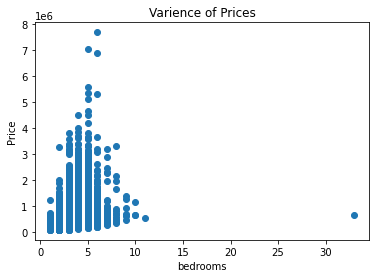

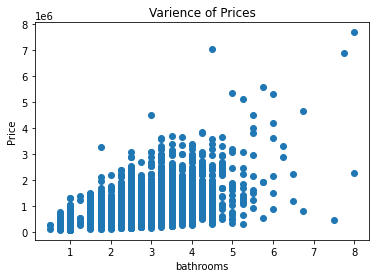

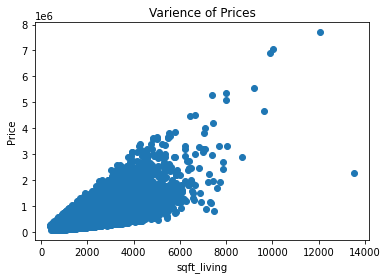

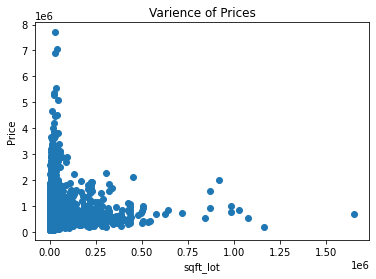

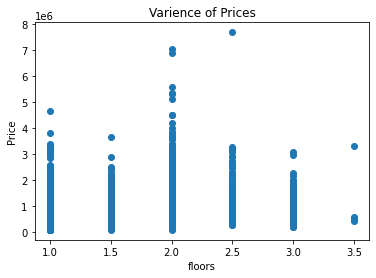

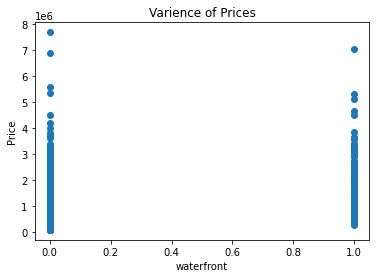

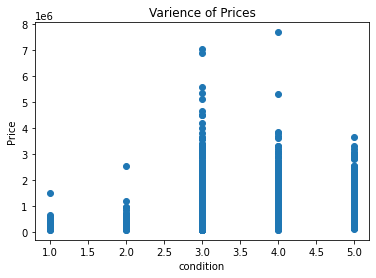

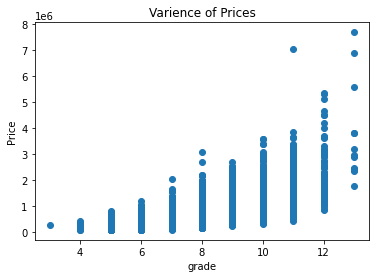

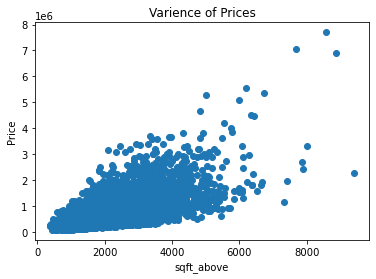

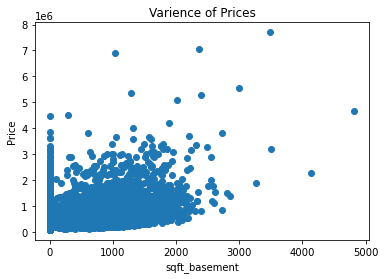

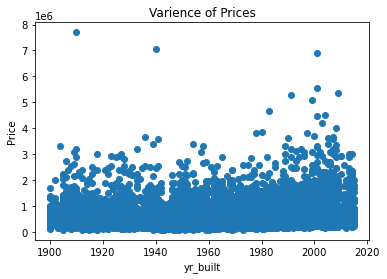

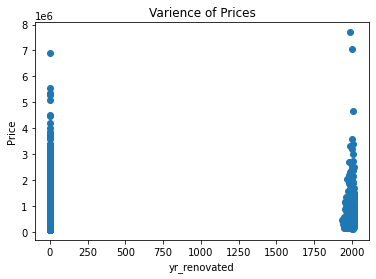

In [62]:
X = df[xCols]
lr = LinearRegression()
lr.fit(X, y)

yPred = lr.predict(X)

print(f"Train Score: {r2_score(y, yPred)}")
print('-----')
print(f"Train Score: {mean_squared_error(y, yPred, squared=False)}")

for x in xCols:
    plt.scatter(df[x], df['price'])
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.title('Varience of Prices')
    plt.show()

Okay, we're seeing a lot of outliers in out data. Let's check a few more plots and see what else we can see.

In [63]:
trainResiduals = yTrain-yPredTrain
testResiduals = yTest-yPredTest
residuals = y-yPred

(array([1.300e+01, 2.110e+03, 4.683e+03, 1.330e+02, 3.200e+01, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([-1172906.48314674,  -628470.39214103,   -84034.30113533,
          460401.78987038,  1004837.88087608,  1549273.97188179,
         2093710.06288749,  2638146.1538932 ,  3182582.2448989 ,
         3727018.33590461,  4271454.42691031]),
 <BarContainer object of 10 artists>)

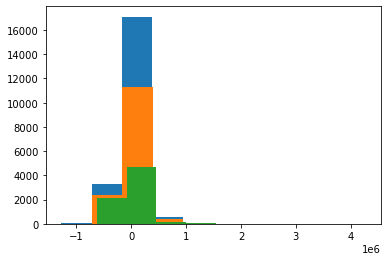

In [64]:
plt.hist(residuals)
plt.hist(trainResiduals)
plt.hist(testResiduals)

Okay, that's some reasuring info. A LARGE majority of the residual data points we're seeing tends to fall very close to the mean. And those that do exist end to exist on the low end with a few on the exreme high end. So removing the outliers from our data wont take away very many values.

C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


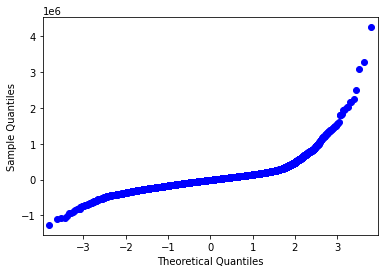

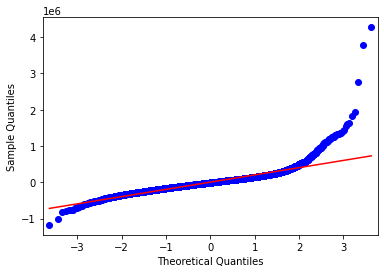

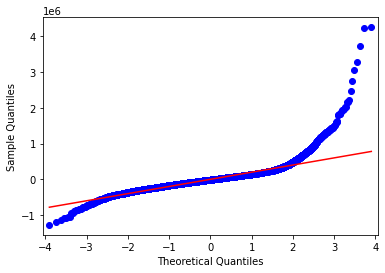

In [65]:
fig = sm.qqplot(trainResiduals, line = 'r')
fig2 = sm.qqplot(testResiduals, line = 'r')
fig3 = sm.qqplot(residuals, line = 'r')

Here we can see the effect those outliers are having. Our trend seems to take a sharp turn up and meters off.

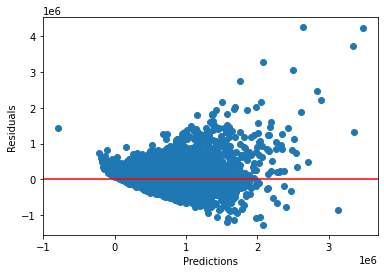

In [66]:
lr = LinearRegression()
lr.fit(X, y)

yPred = lr.predict(X)

plt.scatter(yPred, residuals)
plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

Ouch. This model shows out predictions seem to be extremely scattered. Good news is that they seem to collect in one spot. Bad news is that the spot is about the size and shape of the Big Island of Hawai'i.

# Model 2

## Cleaning the Data

Okay! Let's try this again but armed with the new knowledge from our assessment of Model 1. Just like last time, we'll impoprt our data so we have a fresh model and clean it again. Why don't we go through some of our models and trim off outliers while we're at at?

In [67]:
# Importing the Data, freshhhhhh
df = pd.read_csv("data/kc_house_data.csv")

# Maximum Effort Data Cleaning 
df.drop(['id', 'date', 'view', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
df['waterfront'] = df['waterfront'].fillna(0)
df['yr_renovated'] = df['yr_renovated'].fillna(0)
index_names = df[ df['sqft_basement'] == '?' ].index
df.drop(index_names, inplace = True)
df['sqft_basement'] = df['sqft_basement'].astype(float)

# Data Haircut
df=df[(df['bedrooms'] < 7)]
df=df[(df['bathrooms'] <= 4) & (df['bathrooms'] != 1.25) & (df['bathrooms'] != 0.5)]
df=df[(df['sqft_living'] < 5000)]
df=df[(df['sqft_lot'] < 20000)]
df=df[(df['floors'] <= 3)]
df=df[(df['condition'] > 2)]
df=df[(df['grade'] > 3) & (df['grade'] < 12) & (df['grade'] != 4)]
df=df[(df['sqft_above'] < 6000)]
df=df[(df['sqft_basement'] < 2000)]
df=df[(df['price'] < 2000000)]


In [68]:
# run the model again
xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainScaled = stdScaled.fit_transform(xTrain)
xTestScaled = stdScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Train Score: {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Test Score: {mean_squared_error(yTest, yPredTest, squared=False)}")

Train Score: 0.6093776441118106
Test Score: 0.6033114943854014
-----
Train Score: 164840.90418478948
Test Score: 169668.27224539465


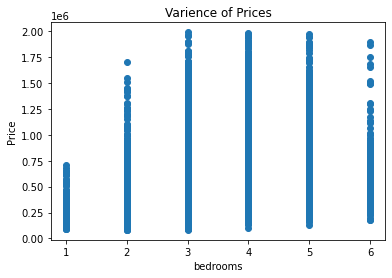

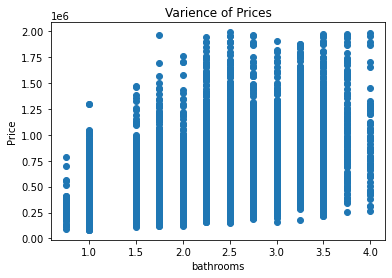

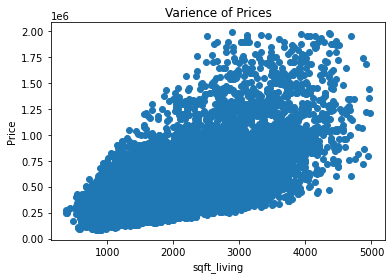

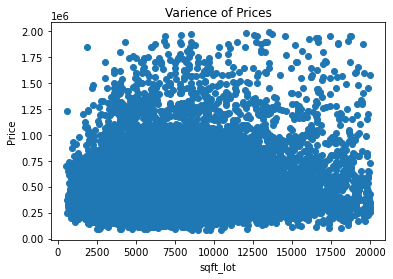

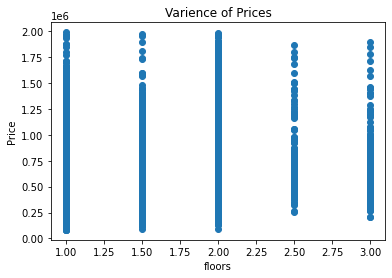

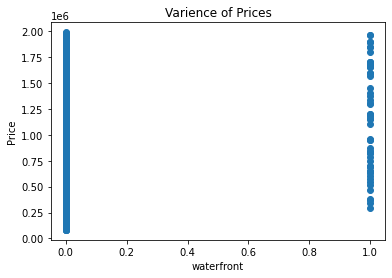

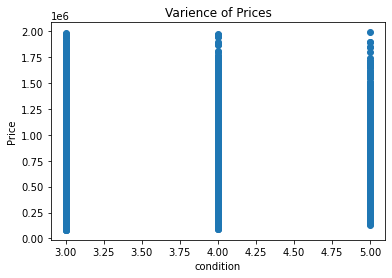

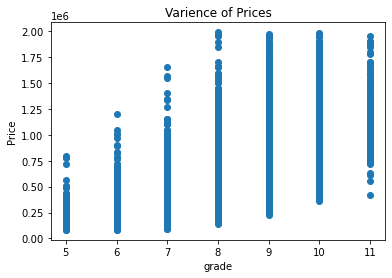

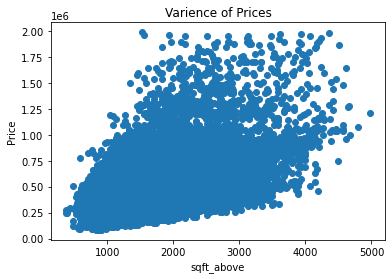

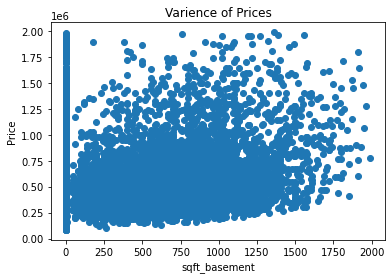

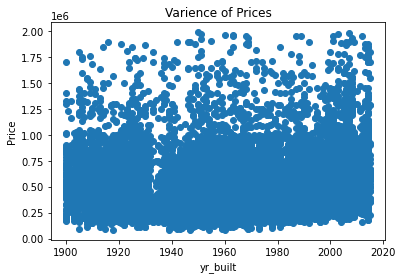

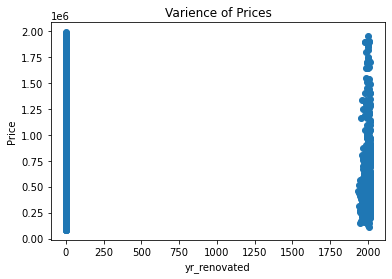

In [69]:
for x in xCols:
    plt.scatter(df[x], df['price'])
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.title('Varience of Prices')
    plt.show()

(array([  26.,  358., 2029., 2673.,  724.,  123.,   70.,   28.,   11.,
           4.]),
 array([-579015.51358404, -401884.20187961, -224752.89017519,
         -47621.57847076,  129509.73323366,  306641.04493808,
         483772.35664251,  660903.66834693,  838034.98005136,
        1015166.29175578, 1192297.6034602 ]),
 <BarContainer object of 10 artists>)

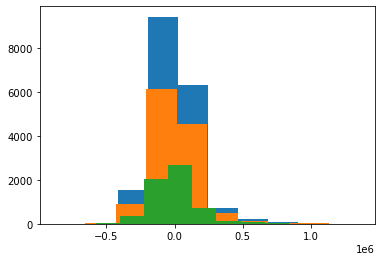

In [70]:
X = df[xCols]
lr = LinearRegression()
lr.fit(X, y)

yPred = lr.predict(X)

trainResiduals = yTrain-yPredTrain
testResiduals = yTest-yPredTest
residuals = y-yPred

plt.hist(residuals)
plt.hist(trainResiduals)
plt.hist(testResiduals)

C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


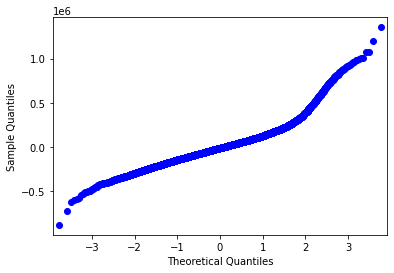

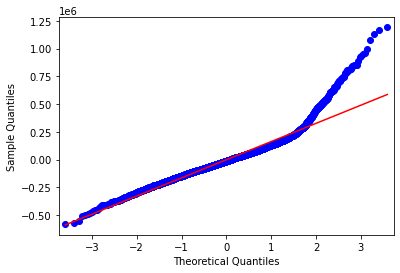

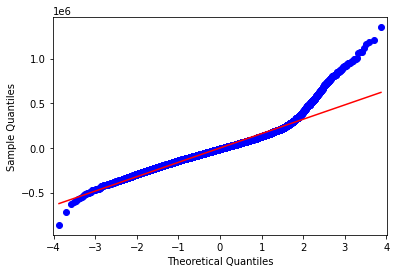

In [71]:
fig = sm.qqplot(trainResiduals, line = 'r')
fig2 = sm.qqplot(testResiduals, line = 'r')
fig3 = sm.qqplot(residuals, line = 'r')

Alright, after fiddling with the data for a long while I've somehow made the model worse. Let's take a step back and reevaluate. Perhaps there's some useful data in what we removed earlier. Let's add some of it back in and see how Our results change purely on that.

# Model 3

Train R2 Score: 0.6961840815077176
Test R2 Score: 0.7101463584756225
-----
Dollar Value Variance (Train): 204582.10359046079
Dollar Value Variance (Test): 202821.66803727273


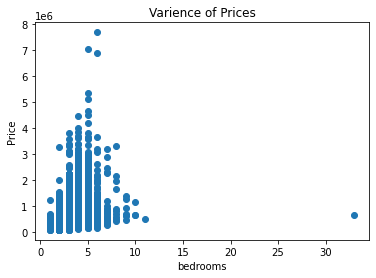

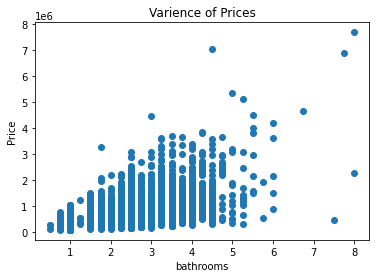

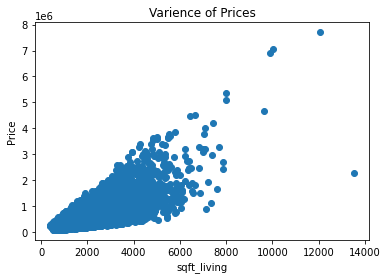

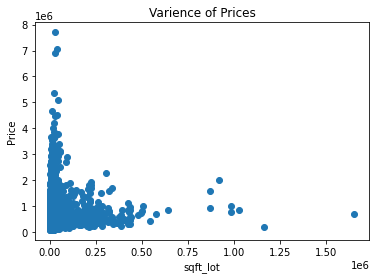

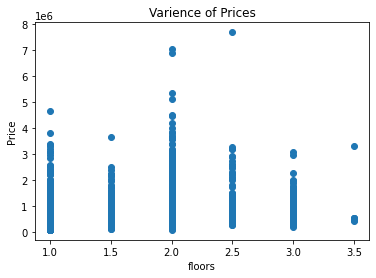

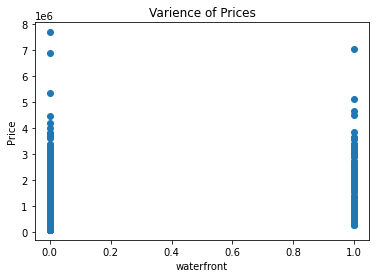

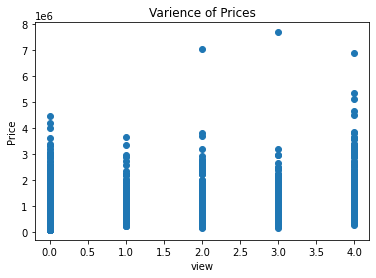

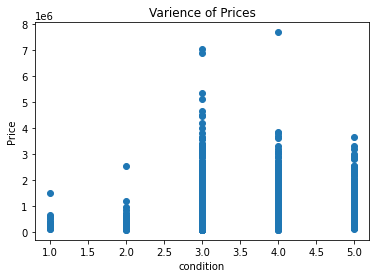

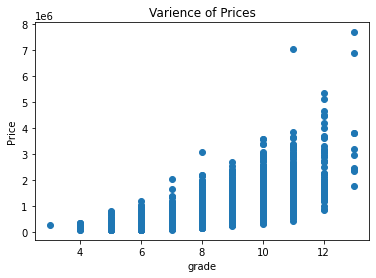

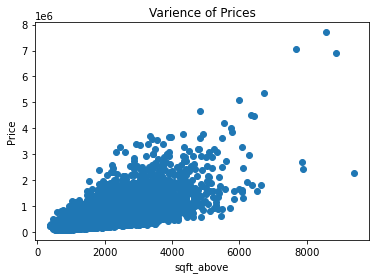

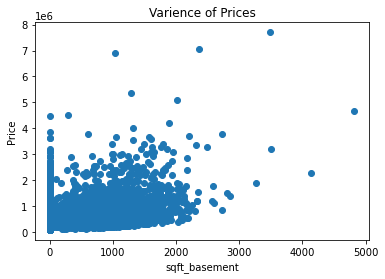

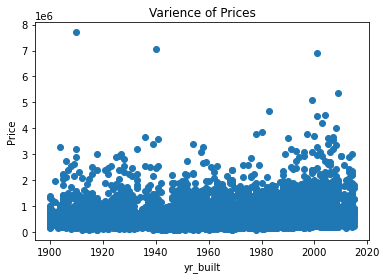

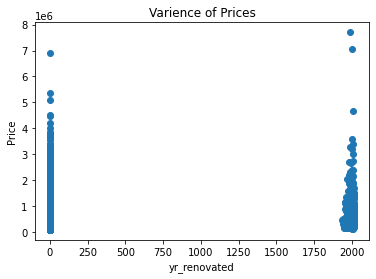

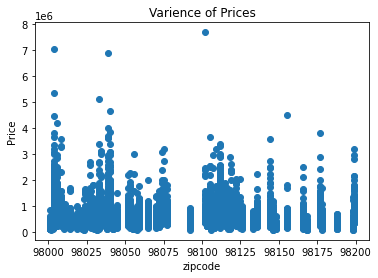

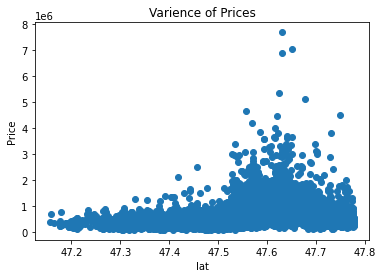

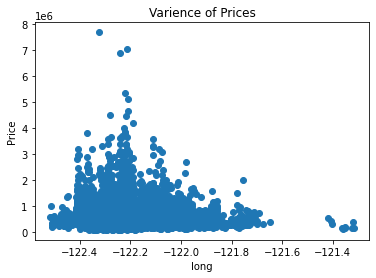

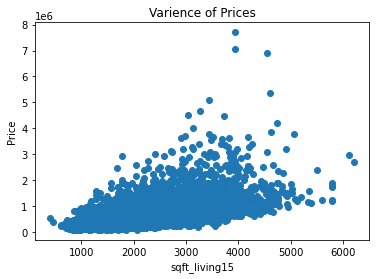

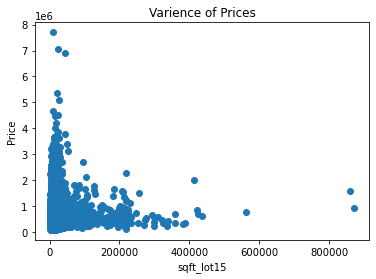

In [72]:
df = pd.read_csv("data/kc_house_data.csv")
# Changes to the list of dropped columns
# Only removed 2 columns ('id' & 'date') this time.
df.drop(['id', 'date'], axis=1, inplace=True)
df = df.dropna()
index_names = df[ df['sqft_basement'] == '?' ].index
df.drop(index_names, inplace = True)
df['sqft_basement'] = df['sqft_basement'].astype(float)
      
xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainScaled = stdScaled.fit_transform(xTrain)
xTestScaled = stdScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train R2 Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test R2 Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Dollar Value Variance (Train): {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Dollar Value Variance (Test): {mean_squared_error(yTest, yPredTest, squared=False)}")

for x in xCols:
    plt.scatter(df[x], df['price'])
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.title('Varience of Prices')
    plt.show()

Oo! Oo! Oo! Progress! We're seeing pregress. We've jumped from 64 to 70 percent and a small decrease in the Dollar Varience. Still not great but we're making progress in thr right direction. Let's check out plots.

(array([1.300e+01, 1.508e+03, 3.476e+03, 7.400e+01, 1.600e+01, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1171491.51630518,  -625859.54764292,   -80227.57898067,
          465404.38968158,  1011036.35834384,  1556668.32700609,
         2102300.29566834,  2647932.2643306 ,  3193564.23299285,
         3739196.20165511,  4284828.17031736]),
 <BarContainer object of 10 artists>)

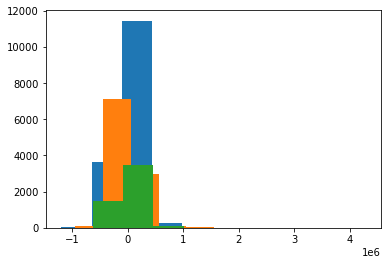

In [73]:
xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

trainResiduals = yTrain-yPredTrain
testResiduals = yTest-yPredTest
lr = LinearRegression()
lr.fit(x, y)

yPred = lr.predict(x)
residuals = y-yPred

plt.hist(residuals)
plt.hist(trainResiduals)
plt.hist(testResiduals)

C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


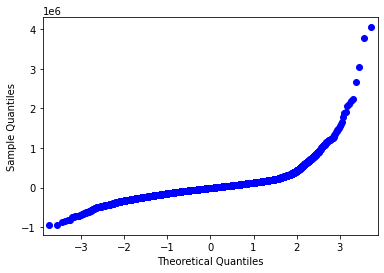

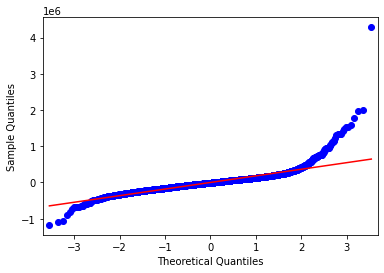

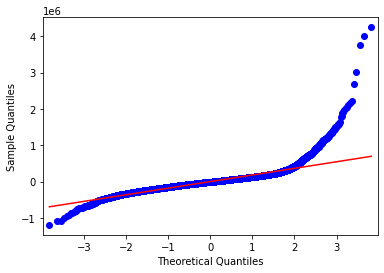

In [74]:
fig = sm.qqplot(trainResiduals, line = 'r')
fig2 = sm.qqplot(testResiduals, line = 'r')
fig3 = sm.qqplot(residuals, line = 'r')

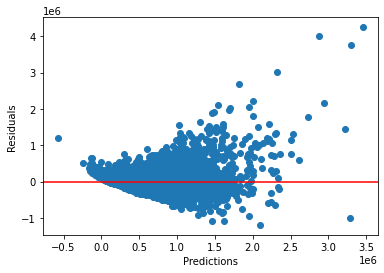

In [75]:
plt.scatter(yPred, residuals)
plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

Nothing has really changed, but that was expected. We haven't trimmed the data on this one. Let's do that and see if we can't make more improvements. Practically just a combination of Models 2 & 3.

# Model 4

Train R2 Score: 0.6936703591900614
Test R2 Score: 0.6756440070126208
-----
Dollar Value Variance (Train): 114395.19879776801
Dollar Value Variance (Test): 117124.95926191621


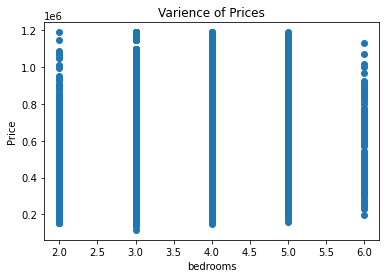

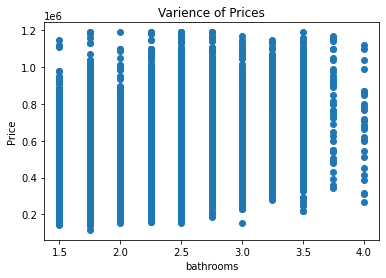

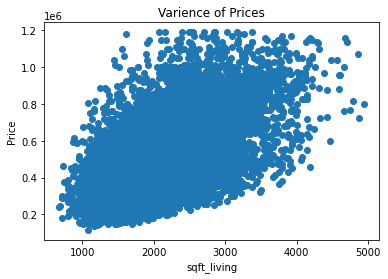

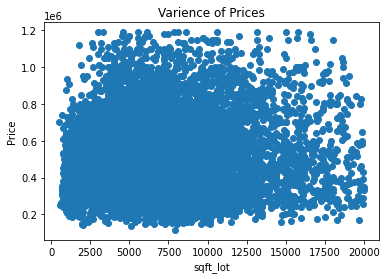

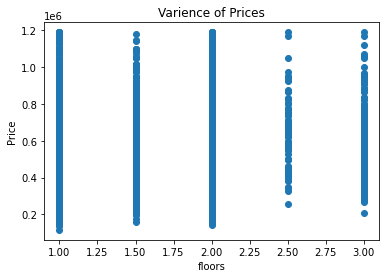

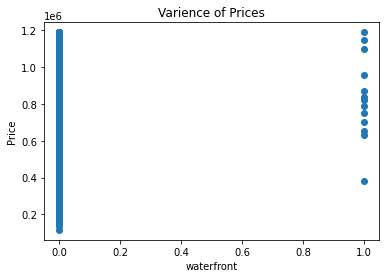

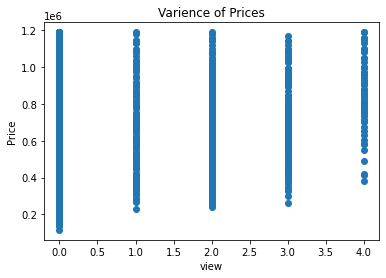

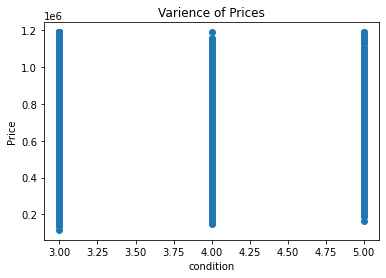

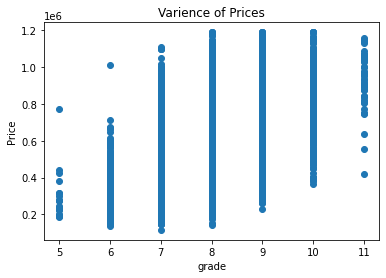

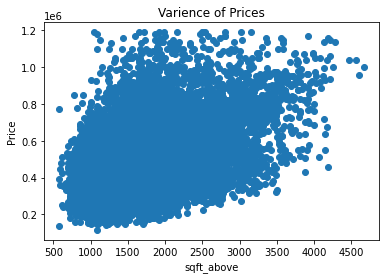

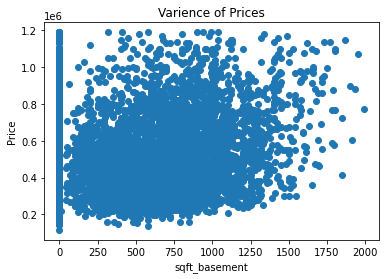

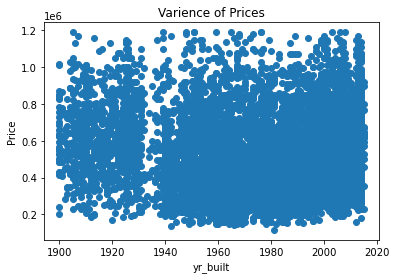

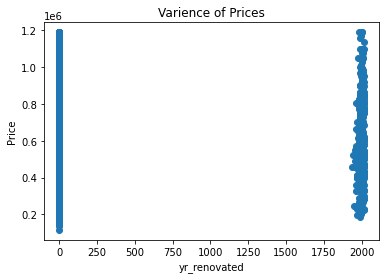

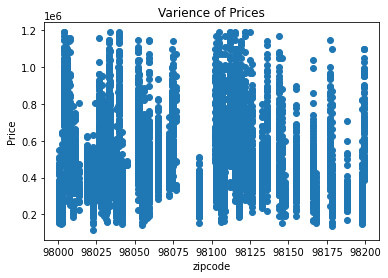

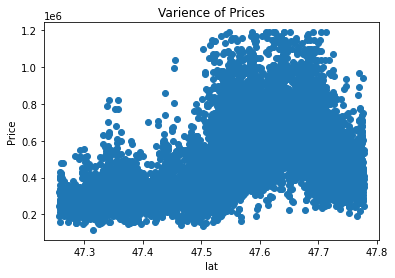

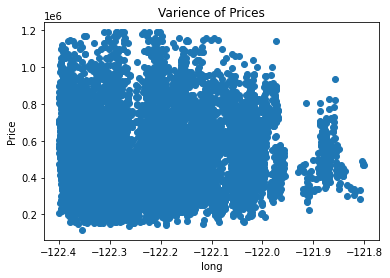

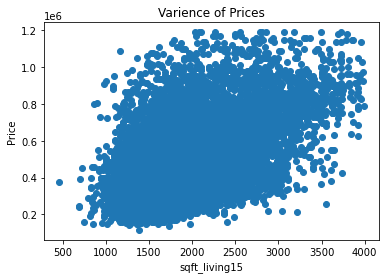

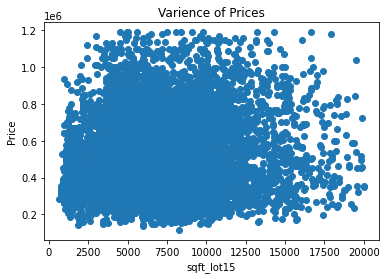

In [76]:
df = pd.read_csv("data/kc_house_data.csv")
# Keeping column list from model 3
df.drop(['id', 'date'], axis=1, inplace=True)
df = df.dropna()
index_names = df[ df['sqft_basement'] == '?' ].index
df.drop(index_names, inplace = True)
df['sqft_basement'] = df['sqft_basement'].astype(float)

# Cleaing from model 2 (but edited a bit)
df=df[(df['bedrooms'] < 7) & (df['bedrooms'] != 1)]
df=df[(df['bathrooms'] <= 4) & (df['bathrooms'] != 1.25) & (df['bathrooms'] > 1)]
df=df[(df['sqft_living'] < 5000)]
df=df[(df['sqft_lot'] < 20000)]
df=df[(df['floors'] <= 3)]
df=df[(df['condition'] > 2)]
df=df[(df['grade'] > 3) & (df['grade'] < 12) & (df['grade'] != 4)]
df=df[(df['sqft_above'] < 6000)]
df=df[(df['sqft_basement'] < 2000)]
df=df[(df['price'] < 1200000) & (df['price'] > 100000)] 

# New data cleaning for new columns
df=df[(df['long'] < -121.8) & (df['long'] > -122.4)]
df=df[(df['lat'] > 47.25)]
df=df[(df['sqft_living15'] < 4000)]
df=df[(df['sqft_lot15'] < 20000)]

xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainScaled = stdScaled.fit_transform(xTrain)
xTestScaled = stdScaled.transform(xTest)

lr = LinearRegression()
lr.fit(xTrainScaled, yTrain)

yPredTrain = lr.predict(xTrainScaled)
yPredTest = lr.predict(xTestScaled)

print(f"Train R2 Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test R2 Score: {r2_score(yTest, yPredTest)}")
print('-----')
print(f"Dollar Value Variance (Train): {mean_squared_error(yTrain, yPredTrain, squared=False)}")
print(f"Dollar Value Variance (Test): {mean_squared_error(yTest, yPredTest, squared=False)}")

for x in xCols:
    plt.scatter(df[x], df['price'])
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.title('Varience of Prices')
    plt.show()

(array([   3.,   11.,   96.,  629., 1430.,  809.,  232.,   72.,   18.,
           5.]),
 array([-533404.25061629, -420541.7521916 , -307679.25376691,
        -194816.75534222,  -81954.25691754,   30908.24150715,
         143770.73993184,  256633.23835652,  369495.73678121,
         482358.2352059 ,  595220.73363059]),
 <BarContainer object of 10 artists>)

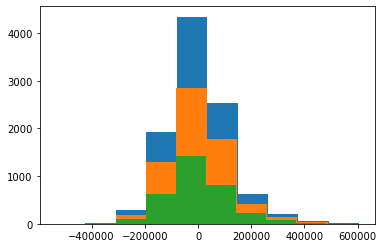

In [77]:
xCols = [c for c in df.columns.to_list() if c not in ['price']]
x = df[xCols]
y = df['price']

trainResiduals = yTrain-yPredTrain
testResiduals = yTest-yPredTest
lr = LinearRegression()
lr.fit(x, y)

yPred = lr.predict(x)
residuals = y-yPred

plt.hist(residuals)
plt.hist(trainResiduals)
plt.hist(testResiduals)

C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


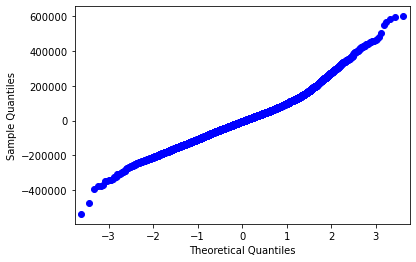

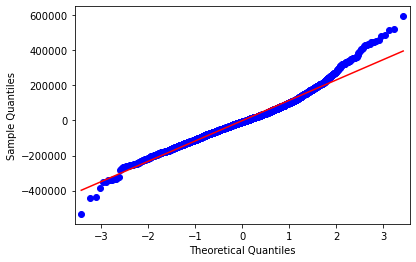

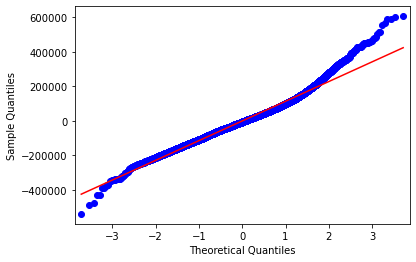

In [78]:
fig = sm.qqplot(trainResiduals, line = 'r')
fig2 = sm.qqplot(testResiduals, line = 'r')
fig3 = sm.qqplot(residuals, line = 'r')

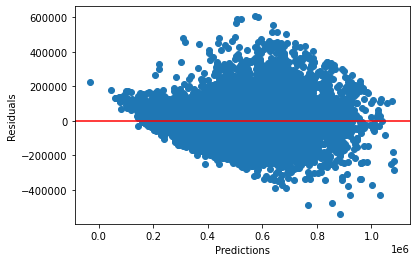

In [79]:
plt.scatter(yPred, residuals)
plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

This is good. We have about a 30% variance on our predictions and parameters on what kinda of housing fits within that prediction. homes have have 
- between 2 and 7 bedrooms
- between 1 and 4 bathrooms but NOT 1.25 bathrooms
- a living space of less than 5,000 sqare feet
- a lot of less than 20,000 square feet
- 3 or less floors
- weather or not it has a waterfront view
- how many people have viewed it in an open house
- a condition rating of greater than 2
- a grade rating between 3 and 12 but NOT 4
- a second floor of less than 6,000 square feet
- a basement of less than 2,000 square feet
- year it was built
- year it was renovated
- zipcode
- a longitude aproximately between -121.8 and -122.4
- a latitude aproximately between 47.3 amd 47.8
- nearest 15 neighbors with a living space of less than 4000
- nearest 15 neighbors with a lot space of less than 4000